# Задание:
1. Загрузите датасет Mall_Customers.csv.
2. Исследуйте новые подходы к кластеризации, основанные на глубоком обучении (например, Deep Embedded Clustering).
3. Сравните их с традиционными методами кластеризации, такими как k-means.
4. Для сравнения используйте метрики.
5. Визуализируйте результаты для двух подходов для двух выбранных признаков.

In [1]:
#@title Установка зависимостей
!pip install -q kagglehub tensorflow scikit-learn matplotlib seaborn numpy pandas > /dev/null 2>&1

In [2]:
#@title Импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Машинное обучение
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Глубокое обучение
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

# Kaggle
import kagglehub

# Настройка для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
#@title Константы и пути
# Параметры модели DEC
EMBEDDING_DIM = 5         # Размерность скрытого представления для DEC
EPOCHS = 200              # Количество эпох для предобучения автоэнкодера
BATCH_SIZE = 32           # Размер батча для обучения
LEARNING_RATE = 0.001     # Скорость обучения

# Параметры обучения DEC
DEC_MAXITER = 2000        # Максимальное количество итераций оптимизации DEC
DEC_UPDATE_INTERVAL = 10  # Интервал обновления меток и метрик
DEC_TOL = 0.001           # Порог сходимости (доля изменений меток)
DEC_MIN_ITER = 50         # Минимальное количество итераций перед проверкой сходимости

# Признаки для визуализации
VIS_FEATURE_1 = 'Annual Income (k$)'
VIS_FEATURE_2 = 'Spending Score (1-100)'

In [4]:
#@title Загрузка данных
path = kagglehub.dataset_download("shwetabh123/mall-customers")
print(f"Путь к датасету: {path}")

df = pd.read_csv(os.path.join(path, "Mall_Customers.csv"))
print(f"\nРазмер датасета: {df.shape}")
print(f"\nПервые 5 строк:")
df.head()

Using Colab cache for faster access to the 'mall-customers' dataset.
Путь к датасету: /kaggle/input/mall-customers

Размер датасета: (200, 5)

Первые 5 строк:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
#@title Исследование данных
print("Информация о датасете:")
print(df.info())
print("\n" + "="*50)
print("\nОписательная статистика:")
print(df.describe())
print("\n" + "="*50)
print("\nПроверка на пропуски:")
print(df.isnull().sum())

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


Описательная статистика:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000        

In [6]:
#@title Подготовка данных
# Создаем копию датасета для обработки
df_processed = df.copy()
df_processed['Genre_encoded'] = df_processed['Genre'].map({'Female': 0, 'Male': 1})

# Выбираем признаки для кластеризации
# Используем только поведенческие признаки: Age, Annual Income, Spending Score
# Genre не включаем, так как бинарный признак может доминировать в кластеризации
# и создавать искусственное разделение по полу вместо реальных паттернов поведения
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Извлекаем данные для кластеризации
X = df_processed[features].values

# Нормализация данных для обеспечения одинакового масштаба признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Форма данных: {X_scaled.shape}")
print(f"Используемые признаки для кластеризации: {features}")
print(f"\nПервые 5 нормализованных строк:")
print(pd.DataFrame(X_scaled, columns=features).head())

Форма данных: (200, 3)
Используемые признаки для кластеризации: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Первые 5 нормализованных строк:
        Age  Annual Income (k$)  Spending Score (1-100)
0 -1.424569           -1.738999               -0.434801
1 -1.281035           -1.738999                1.195704
2 -1.352802           -1.700830               -1.715913
3 -1.137502           -1.700830                1.040418
4 -0.563369           -1.662660               -0.395980


In [7]:
#@title Вспомогательные функции для оценки кластеризации
def evaluate_clustering(X, labels, method_name):
    """
    Вычисляет метрики качества кластеризации.

    Args:
        X (np.ndarray): Массив признаков формы (n_samples, n_features).
        labels (np.ndarray): Массив меток кластеров формы (n_samples,).
        method_name (str): Название метода кластеризации для отображения.

    Returns:
        dict: Словарь с метриками качества кластеризации:
            - 'Method': название метода
            - 'Silhouette Score': коэффициент силуэта (чем выше, тем лучше)
            - 'Calinski-Harabasz Score': индекс Калинского-Харабаша (чем выше, тем лучше)
            - 'Davies-Bouldin Score': индекс Дэвиса-Болдина (чем ниже, тем лучше)
    """
    metrics = {
        'Method': method_name,
        'Silhouette Score': silhouette_score(X, labels),
        'Calinski-Harabasz Score': calinski_harabasz_score(X, labels),
        'Davies-Bouldin Score': davies_bouldin_score(X, labels)
    }

    return metrics


def plot_clusters(X, labels, centroids=None, title="Кластеризация",
                  feature1_idx=1, feature2_idx=2, feature_names=None):
    """
    Визуализирует результаты кластеризации в 2D пространстве двух признаков.

    Args:
        X (np.ndarray): Массив признаков формы (n_samples, n_features).
        labels (np.ndarray): Массив меток кластеров формы (n_samples,).
        centroids (np.ndarray, optional): Массив центроидов формы (n_clusters, n_features).
            Если None, центроиды не отображаются.
        title (str): Заголовок графика. По умолчанию "Кластеризация".
        feature1_idx (int): Индекс первого признака для оси X. По умолчанию 1.
        feature2_idx (int): Индекс второго признака для оси Y. По умолчанию 2.
        feature_names (list, optional): Список названий признаков для подписей осей.
            Если None, используются индексы признаков.

    Returns:
        None: Функция только отображает график.
    """
    plt.figure(figsize=(10, 7))

    scatter = plt.scatter(X[:, feature1_idx], X[:, feature2_idx],
                         c=labels, cmap='viridis', s=50, alpha=0.6, edgecolors='black')

    if centroids is not None:
        plt.scatter(centroids[:, feature1_idx], centroids[:, feature2_idx],
                   marker='x', s=300, c='red', linewidths=3, label='Центроиды')

    plt.colorbar(scatter, label='Кластер')

    if feature_names:
        plt.xlabel(feature_names[feature1_idx])
        plt.ylabel(feature_names[feature2_idx])
    else:
        plt.xlabel(f'Признак {feature1_idx}')
        plt.ylabel(f'Признак {feature2_idx}')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Исследование оптимального количества кластеров...
Используем метод локтя и Silhouette Score для определения оптимального K



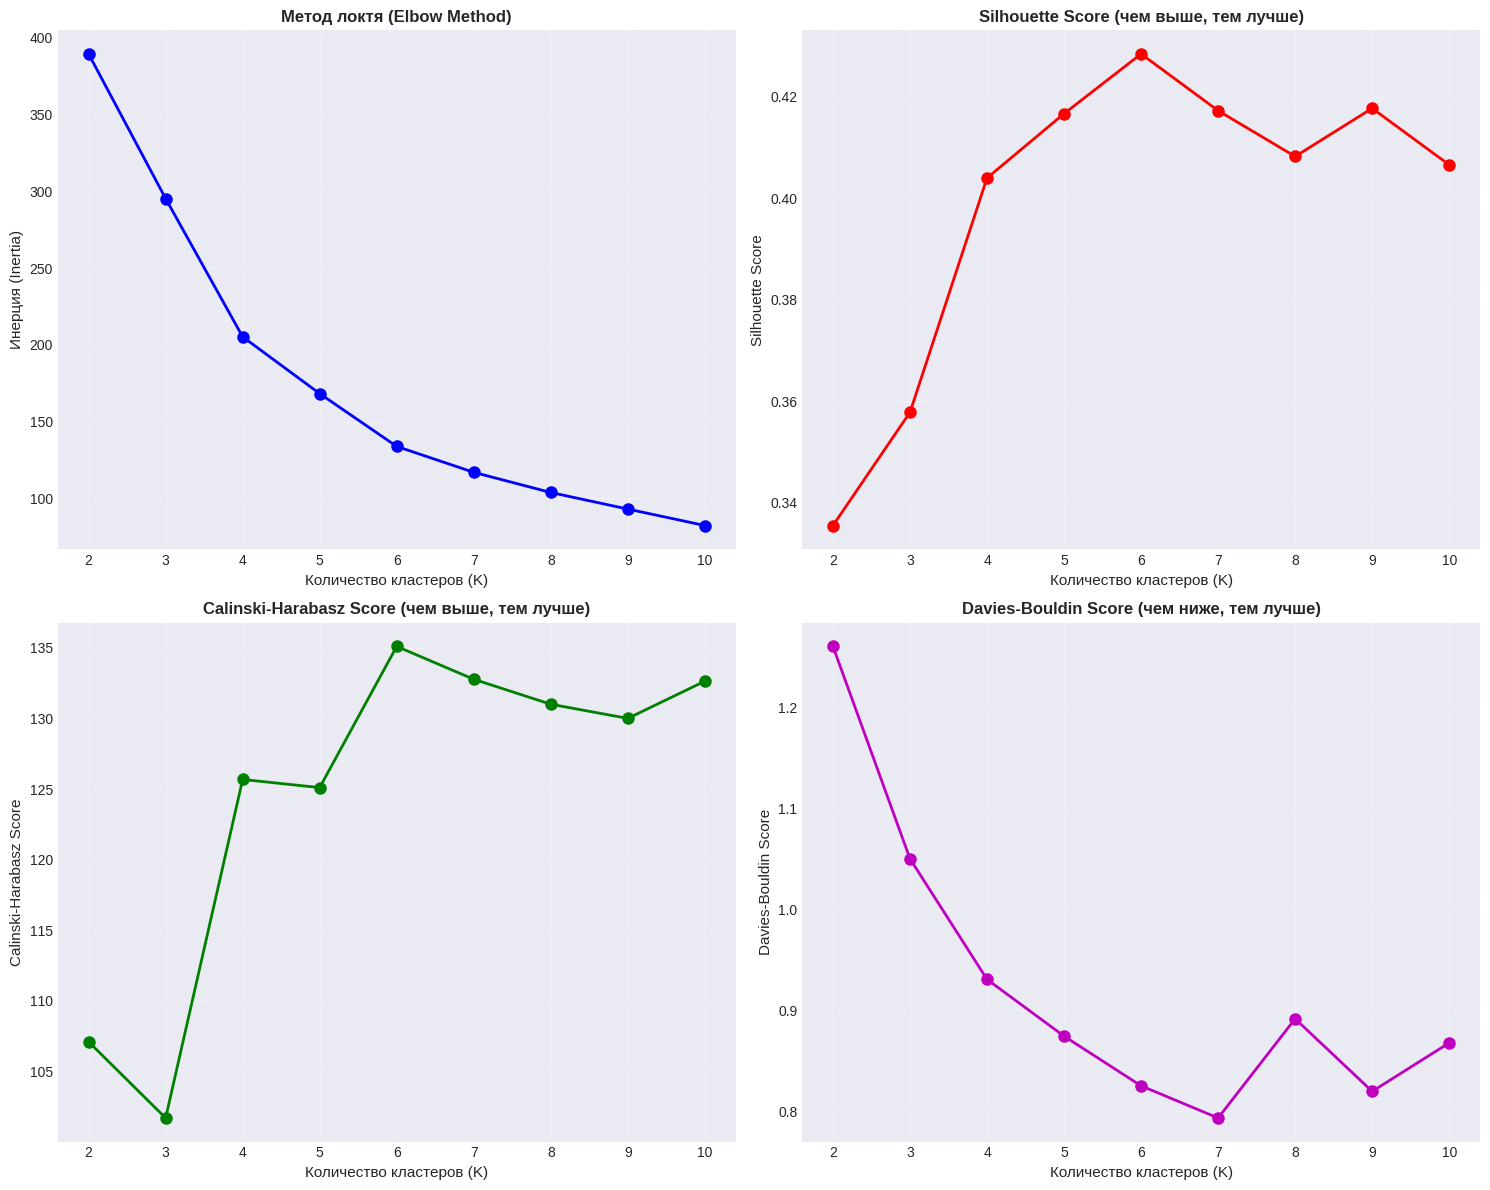


РЕЗУЛЬТАТЫ ИССЛЕДОВАНИЯ ОПТИМАЛЬНОГО КОЛИЧЕСТВА КЛАСТЕРОВ:
Оптимальное K по Silhouette Score: 6 (значение: 0.4284)
Оптимальное K по Calinski-Harabasz Score: 6 (значение: 135.1021)
Оптимальное K по Davies-Bouldin Score: 7 (значение: 0.7935)

Выбранное оптимальное количество кластеров: K = 6


In [8]:
#@title Определение оптимального количества кластеров
print("Исследование оптимального количества кластеров...")
print("Используем метод локтя и Silhouette Score для определения оптимального K\n")

inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

# Визуализация методов определения оптимального K
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Метод локтя
ax1 = axes[0, 0]
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Количество кластеров (K)', fontsize=11)
ax1.set_ylabel('Инерция (Inertia)', fontsize=11)
ax1.set_title('Метод локтя (Elbow Method)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(K_range)

# Silhouette Score
ax2 = axes[0, 1]
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Количество кластеров (K)', fontsize=11)
ax2.set_ylabel('Silhouette Score', fontsize=11)
ax2.set_title('Silhouette Score (чем выше, тем лучше)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(K_range)

# Calinski-Harabasz Score
ax3 = axes[1, 0]
ax3.plot(K_range, calinski_scores, 'go-', linewidth=2, markersize=8)
ax3.set_xlabel('Количество кластеров (K)', fontsize=11)
ax3.set_ylabel('Calinski-Harabasz Score', fontsize=11)
ax3.set_title('Calinski-Harabasz Score (чем выше, тем лучше)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(K_range)

# Davies-Bouldin Score
ax4 = axes[1, 1]
ax4.plot(K_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
ax4.set_xlabel('Количество кластеров (K)', fontsize=11)
ax4.set_ylabel('Davies-Bouldin Score', fontsize=11)
ax4.set_title('Davies-Bouldin Score (чем ниже, тем лучше)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_xticks(K_range)

plt.tight_layout()
plt.show()

# Находим оптимальное K по разным метрикам
K_list = list(K_range)
optimal_k_silhouette = K_list[np.argmax(silhouette_scores)]
optimal_k_calinski = K_list[np.argmax(calinski_scores)]
optimal_k_davies = K_list[np.argmin(davies_bouldin_scores)]

print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ ИССЛЕДОВАНИЯ ОПТИМАЛЬНОГО КОЛИЧЕСТВА КЛАСТЕРОВ:")
print("="*70)
print(f"Оптимальное K по Silhouette Score: {optimal_k_silhouette} (значение: {max(silhouette_scores):.4f})")
print(f"Оптимальное K по Calinski-Harabasz Score: {optimal_k_calinski} (значение: {max(calinski_scores):.4f})")
print(f"Оптимальное K по Davies-Bouldin Score: {optimal_k_davies} (значение: {min(davies_bouldin_scores):.4f})")

# Выбираем оптимальное K (приоритет Silhouette Score)
N_CLUSTERS = optimal_k_silhouette
print(f"\nВыбранное оптимальное количество кластеров: K = {N_CLUSTERS}")

In [9]:
#@title K-Means кластеризация
print("Применение K-Means кластеризации...")

# Создаем и обучаем модель K-Means
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_centroids = kmeans.cluster_centers_

Применение K-Means кластеризации...


In [10]:
#@title Реализация Deep Embedded Clustering (DEC)
class DeepEmbeddedClustering:
    """
    Реализация алгоритма Deep Embedded Clustering (DEC).

    DEC объединяет автоэнкодер для извлечения признаков и кластеризацию
    в скрытом пространстве. Алгоритм состоит из двух этапов:
    1. Предобучение автоэнкодера для получения хорошего представления данных
    2. Совместная оптимизация представления и кластеризации

    Attributes:
        input_dim (int): Размерность входных данных.
        n_clusters (int): Количество кластеров.
        latent_dim (int): Размерность скрытого представления.
        alpha (float): Параметр регуляризации для распределения вероятностей.
        encoder (tf.keras.Model): Модель энкодера.
        autoencoder (tf.keras.Model): Полная модель автоэнкодера.
        dec_model (tf.keras.Model): Модель DEC для кластеризации.
        labels_ (np.ndarray): Метки кластеров после обучения.
    """

    def __init__(
        self,
        input_dim,
        n_clusters=5,
        latent_dim=10,
        alpha=1.0
    ):
        """
        Инициализирует модель Deep Embedded Clustering.

        Args:
            input_dim (int): Размерность входных признаков.
            n_clusters (int, optional): Количество кластеров. По умолчанию 5.
            latent_dim (int, optional): Размерность скрытого представления. По умолчанию 10.
            alpha (float, optional): Параметр регуляризации для распределения вероятностей.
                По умолчанию 1.0.
        """
        self.input_dim = input_dim
        self.n_clusters = n_clusters
        self.latent_dim = latent_dim
        self.alpha = alpha

        self._build_autoencoder()
        self._build_dec_model()

    def _build_autoencoder(self):
        """
        Строит архитектуру автоэнкодера.

        Архитектура: Input -> Dense(16) -> Dropout -> Dense(8) -> Latent ->
                     Dense(8) -> Dropout -> Dense(16) -> Output

        Создает модели encoder и autoencoder с использованием dropout для регуляризации.

        Returns:
            None: Модели сохраняются в self.encoder и self.autoencoder.
        """
        inputs = layers.Input(shape=(self.input_dim,))

        # Энкодер
        x = layers.Dense(16, activation="relu")(inputs)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(8, activation="relu")(x)
        latent = layers.Dense(self.latent_dim, name="latent")(x)

        # Декодер
        x = layers.Dense(8, activation="relu")(latent)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(16, activation="relu")(x)
        outputs = layers.Dense(self.input_dim, name="output")(x)

        self.encoder = models.Model(inputs, latent, name="encoder")
        self.autoencoder = models.Model(inputs, outputs, name="autoencoder")

        self.autoencoder.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="mse"
        )

    class ClusteringLayer(layers.Layer):
        """
        Кастомный слой для вычисления мягких назначений точек к кластерам.

        Вычисляет распределение вероятностей принадлежности каждой точки
        к каждому кластеру на основе расстояний до центроидов.
        """

        def __init__(self, n_clusters, alpha=1.0, **kwargs):
            """
            Инициализирует ClusteringLayer.

            Args:
                n_clusters (int): Количество кластеров.
                alpha (float): Параметр регуляризации. По умолчанию 1.0.
                **kwargs: Дополнительные аргументы для базового класса Layer.
            """
            super().__init__(**kwargs)
            self.n_clusters = n_clusters
            self.alpha = alpha

        def build(self, input_shape):
            """
            Создает веса слоя (центроиды кластеров).

            Args:
                input_shape: Форма входных данных (batch_size, latent_dim).
            """
            self.clusters = self.add_weight(
                shape=(self.n_clusters, input_shape[1]),
                initializer="glorot_uniform",
                name="clusters"
            )

        def call(self, inputs):
            """
            Вычисляет мягкие назначения точек к кластерам.

            Args:
                inputs (tf.Tensor): Входные данные формы (batch_size, latent_dim).

            Returns:
                tf.Tensor: Матрица распределения вероятностей формы (batch_size, n_clusters).
            """
            q = 1.0 / (
                1.0 + (
                    K.sum(
                        K.square(
                            K.expand_dims(inputs, axis=1) - self.clusters
                        ),
                        axis=2
                    ) / self.alpha
                )
            )
            q **= (self.alpha + 1.0) / 2.0
            q = q / K.sum(q, axis=1, keepdims=True)
            return q

    def _build_dec_model(self):
        """
        Строит модель DEC, объединяющую энкодер и слой кластеризации.

        Returns:
            None: Модель сохраняется в self.dec_model.
        """
        clustering_output = self.ClusteringLayer(
            self.n_clusters,
            self.alpha
        )(self.encoder.output)

        self.dec_model = models.Model(
            inputs=self.encoder.input,
            outputs=clustering_output
        )

        self.dec_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.KLDivergence()
        )

    @staticmethod
    def target_distribution(q):
        """
        Вычисляет целевую распределение p из распределения q.

        Используется для оптимизации кластеризации через минимизацию
        KL-дивергенции между p и q.

        Args:
            q (np.ndarray): Матрица мягких назначений формы (n_samples, n_clusters).

        Returns:
            np.ndarray: Целевая распределение p формы (n_samples, n_clusters).
        """
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def fit(
        self,
        X,
        pretrain_epochs=100,
        batch_size=32,
        maxiter=1000,
        update_interval=50,
        tol=1e-3,
        min_iter=50
    ):
        """
        Обучает модель DEC на данных.

        Процесс обучения состоит из трех этапов:
        1. Предобучение автоэнкодера для получения хорошего представления
        2. Инициализация кластеров с помощью K-Means на скрытом представлении
        3. Итеративная оптимизация представления и кластеризации

        Args:
            X (np.ndarray): Массив признаков формы (n_samples, n_features).
            pretrain_epochs (int, optional): Количество эпох предобучения автоэнкодера.
                По умолчанию 100.
            batch_size (int, optional): Размер батча для обучения. По умолчанию 32.
            maxiter (int, optional): Максимальное количество итераций оптимизации DEC.
                По умолчанию 1000.
            update_interval (int, optional): Интервал обновления меток и метрик.
                По умолчанию 50.
            tol (float, optional): Порог сходимости (доля изменений меток).
                По умолчанию 1e-3.
            min_iter (int, optional): Минимальное количество итераций перед проверкой сходимости.
                По умолчанию 50.

        Returns:
            self: Возвращает self для поддержки цепочки вызовов.
        """
        print("Обучение Deep Embedded Clustering...")

        # Этап 1: Предобучение автоэнкодера
        print("Предобучение автоэнкодера...")
        print(f"Количество эпох: {pretrain_epochs}, Размер батча: {batch_size}")

        history = self.autoencoder.fit(
            X, X,
            epochs=pretrain_epochs,
            batch_size=batch_size,
            verbose=1,
            shuffle=True
        )

        final_loss = history.history['loss'][-1]
        print(f"Предобучение завершено. Финальная ошибка: {final_loss:.6f}")

        # Этап 2: Инициализация кластеров с помощью K-Means
        print("Инициализация кластеров с помощью K-Means...")
        latent = self.encoder.predict(X, verbose=0)
        kmeans = KMeans(
            n_clusters=self.n_clusters,
            n_init=20,
            random_state=42
        )
        y_pred = kmeans.fit_predict(latent)

        # Инициализация весов модели DEC
        _ = self.dec_model.predict(X[:1], verbose=0)

        # Находим ClusteringLayer и устанавливаем центроиды кластеров
        clustering_layer = self.dec_model.layers[-1]

        if not isinstance(clustering_layer, self.ClusteringLayer):
            for layer in self.dec_model.layers:
                if isinstance(layer, self.ClusteringLayer):
                    clustering_layer = layer
                    break

        if hasattr(clustering_layer, 'clusters'):
            clustering_layer.clusters.assign(tf.constant(kmeans.cluster_centers_, dtype=tf.float32))
        else:
            clustering_layer.set_weights([kmeans.cluster_centers_])

        print("Инициализация завершена")

        # Этап 3: Итеративная оптимизация кластеризации
        print("Начало оптимизации DEC...")

        y_pred_last = y_pred
        best_sil_score = -1
        best_labels = y_pred.copy()
        patience = 20
        no_improvement = 0

        for ite in range(maxiter):
            q = self.dec_model.predict(X, verbose=0)
            p = self.target_distribution(q)

            # Выполняем несколько шагов обучения для лучшей сходимости
            for _ in range(3):
                loss = self.dec_model.train_on_batch(X, p)

            q = self.dec_model.predict(X, verbose=0)

            if ite % update_interval == 0:
                y_pred = q.argmax(1)
                delta = np.sum(y_pred != y_pred_last) / y_pred.shape[0]
                y_pred_last = y_pred

                sil_score = silhouette_score(X, y_pred)
                print(f"Итерация {ite}: Loss = {loss:.4f}, Delta = {delta:.4f}, Silhouette Score = {sil_score:.4f}")

                if sil_score > best_sil_score:
                    best_sil_score = sil_score
                    best_labels = y_pred.copy()
                    no_improvement = 0
                else:
                    no_improvement += 1

                if ite >= min_iter and delta < tol:
                    print(f"\nСходимость достигнута на итерации {ite} (delta = {delta:.4f} < tol = {tol})")
                    break

                if no_improvement >= patience:
                    print(f"\nРанняя остановка на итерации {ite} (нет улучшения {patience} итераций)")
                    break

        self.labels_ = best_labels
        self.labels = best_labels
        print(f"Обучение завершено! Лучший Silhouette Score: {best_sil_score:.4f}")
        return self

In [11]:
#@title Применение Deep Embedded Clustering
print("Применение Deep Embedded Clustering...")


# Создаем и обучаем модель DEC
dec = DeepEmbeddedClustering(
    input_dim=X_scaled.shape[1],
    n_clusters=N_CLUSTERS,
    latent_dim=EMBEDDING_DIM,
    alpha=1.0
)

dec.fit(
    X_scaled,
    pretrain_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    maxiter=DEC_MAXITER,
    update_interval=DEC_UPDATE_INTERVAL,
    tol=DEC_TOL,
    min_iter=DEC_MIN_ITER
)

dec_labels = dec.labels_

# Перенумеровываем метки, чтобы они были последовательными от 0 до количества кластеров-1
label_encoder = LabelEncoder()
dec_labels = label_encoder.fit_transform(dec_labels)

Применение Deep Embedded Clustering...
Обучение Deep Embedded Clustering...
Предобучение автоэнкодера...
Количество эпох: 200, Размер батча: 32
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1.0492
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0113
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9865
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9799
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9552
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9403
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9408
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9257
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9046 
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8917
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8714 
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8597
Epoch 13/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8478
Epoch


СРАВНЕНИЕ МЕТОДОВ КЛАСТЕРИЗАЦИИ
                          Silhouette Score  Calinski-Harabasz Score  Davies-Bouldin Score
Method                                                                                   
K-Means                           0.428417               135.102104              0.825354
Deep Embedded Clustering          0.359724               103.789684              0.957761


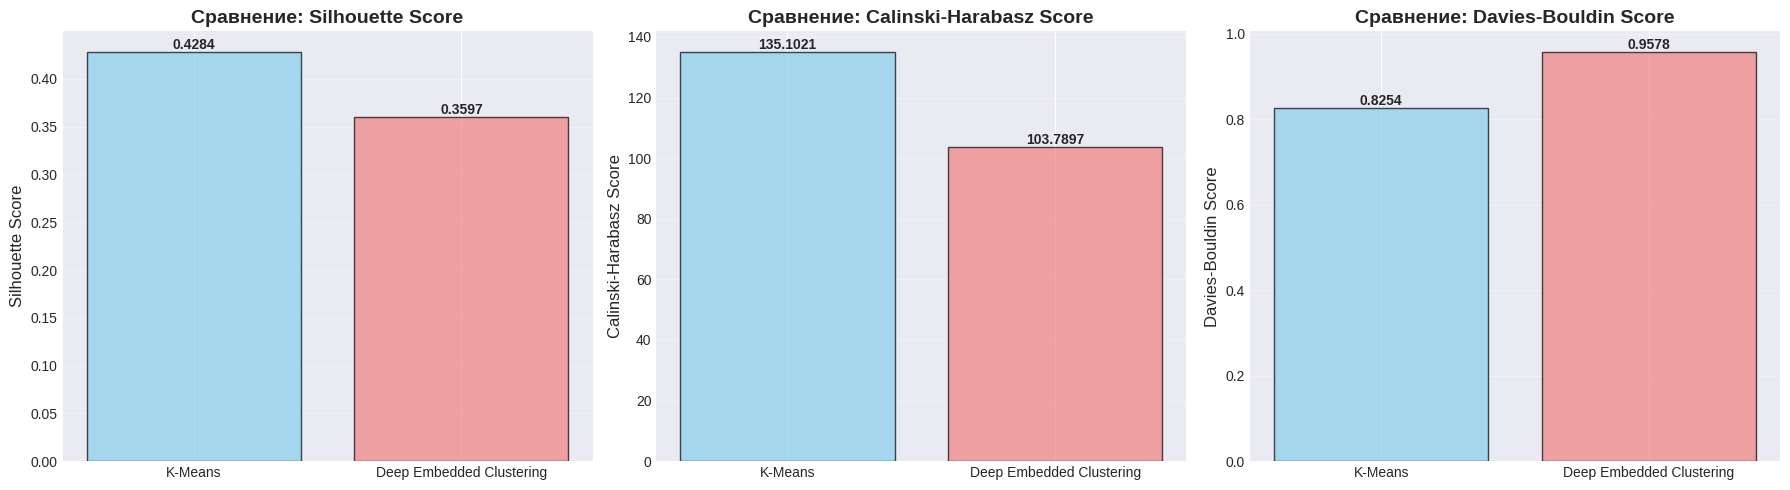

In [12]:
#@title Сравнение методов кластеризации
# Вычисляем метрики для обоих методов
kmeans_metrics = evaluate_clustering(X_scaled, kmeans_labels, "K-Means")
dec_metrics = evaluate_clustering(X_scaled, dec_labels, "Deep Embedded Clustering")

# Создаем таблицу сравнения метрик
comparison_df = pd.DataFrame([kmeans_metrics, dec_metrics])
comparison_df = comparison_df.set_index('Method')

print("\n" + "="*70)
print("СРАВНЕНИЕ МЕТОДОВ КЛАСТЕРИЗАЦИИ")
print("="*70)
print(comparison_df.to_string())
print("="*70)

# Визуализация сравнения метрик
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']
colors = ['skyblue', 'lightcoral']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df.index, values, color=colors[:len(values)], alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'Сравнение: {metric}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')

plt.tight_layout()
plt.show()

# Интерпретация метрик

1. Silhouette Score (чем выше, тем лучше):
   - Диапазон: [-1, 1]
   - Оценивает, насколько хорошо точки соответствуют своим кластерам
   - Значение близкое к 1 означает отличную кластеризацию

2. Calinski-Harabasz Score (чем выше, тем лучше):
   - Оценивает отношение межкластерной дисперсии к внутрикластерной
   - Высокое значение означает хорошо разделенные кластеры

3. Davies-Bouldin Score (чем ниже, тем лучше):
   - Оценивает среднее отношение внутрикластерного расстояния к межкластерному
   - Низкое значение означает компактные и хорошо разделенные кластеры

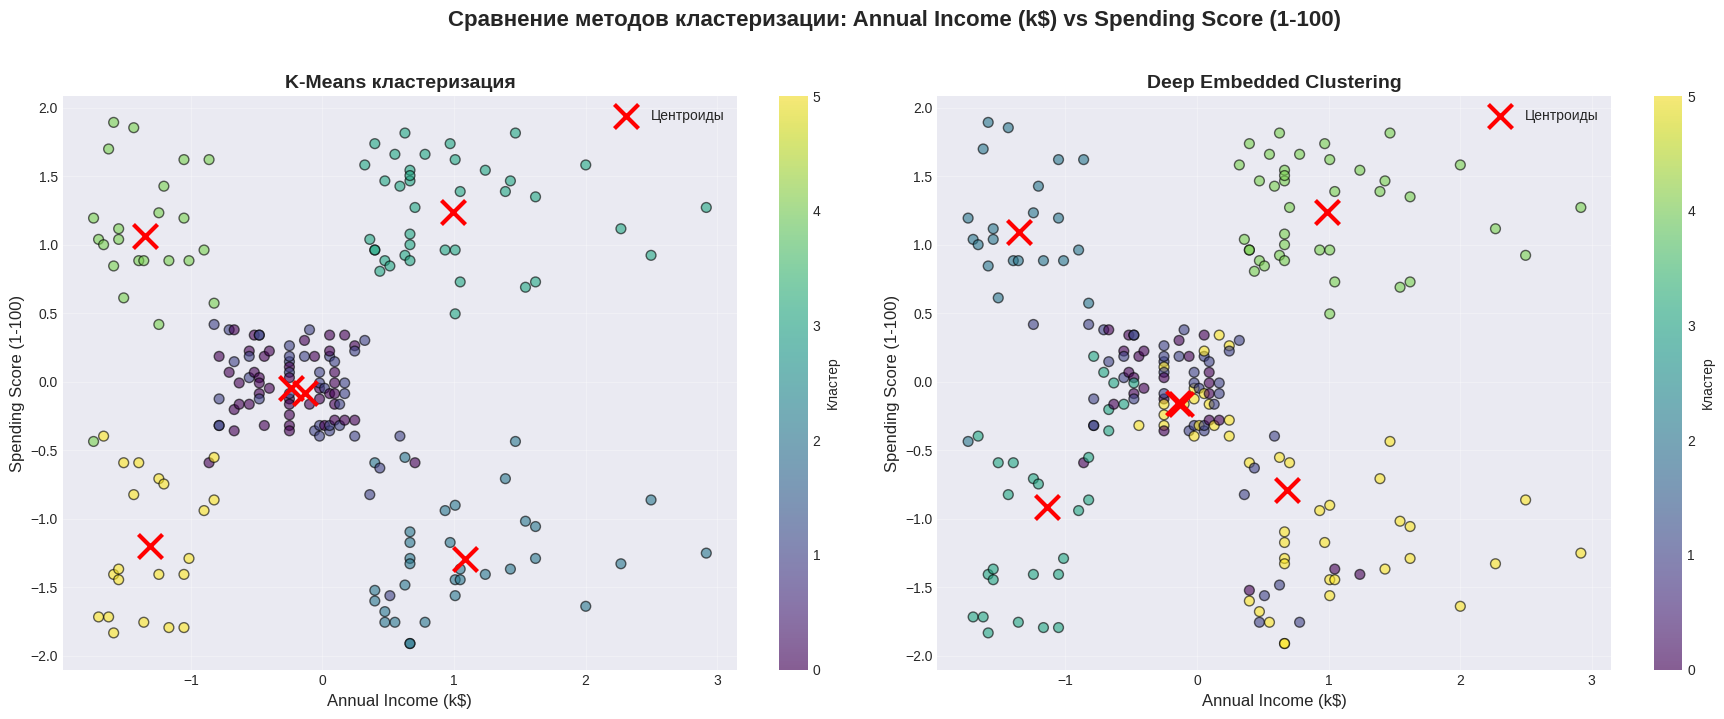

In [13]:
#@title Визуализация результатов для двух выбранных признаков
# Создаем фигуру с двумя подграфиками для сравнения
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

feature_indices = [features.index(VIS_FEATURE_1), features.index(VIS_FEATURE_2)]

# K-Means визуализация
ax1 = axes[0]
scatter1 = ax1.scatter(X_scaled[:, feature_indices[0]],
                      X_scaled[:, feature_indices[1]],
                      c=kmeans_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='black')
ax1.scatter(kmeans_centroids[:, feature_indices[0]],
           kmeans_centroids[:, feature_indices[1]],
           marker='x', s=300, c='red', linewidths=3, label='Центроиды')
ax1.set_xlabel(features[feature_indices[0]], fontsize=12)
ax1.set_ylabel(features[feature_indices[1]], fontsize=12)
ax1.set_title('K-Means кластеризация', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Кластер')

# DEC визуализация
ax2 = axes[1]
scatter2 = ax2.scatter(X_scaled[:, feature_indices[0]],
                       X_scaled[:, feature_indices[1]],
                       c=dec_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='black')

# Вычисляем центроиды DEC в исходном пространстве признаков
# (средние значения точек каждого кластера)
dec_centroids = []
unique_dec_labels = np.unique(dec_labels)
for cluster_id in sorted(unique_dec_labels):
    cluster_mask = dec_labels == cluster_id
    if np.sum(cluster_mask) > 0:
        centroid = np.mean(X_scaled[cluster_mask], axis=0)
        dec_centroids.append(centroid)
dec_centroids = np.array(dec_centroids)

# Отображаем центроиды DEC
if len(dec_centroids) > 0:
    ax2.scatter(dec_centroids[:, feature_indices[0]],
               dec_centroids[:, feature_indices[1]],
               marker='x', s=300, c='red', linewidths=3, label='Центроиды')

ax2.set_xlabel(features[feature_indices[0]], fontsize=12)
ax2.set_ylabel(features[feature_indices[1]], fontsize=12)
ax2.set_title('Deep Embedded Clustering', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Кластер')

plt.suptitle(f'Сравнение методов кластеризации: {VIS_FEATURE_1} vs {VIS_FEATURE_2}',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

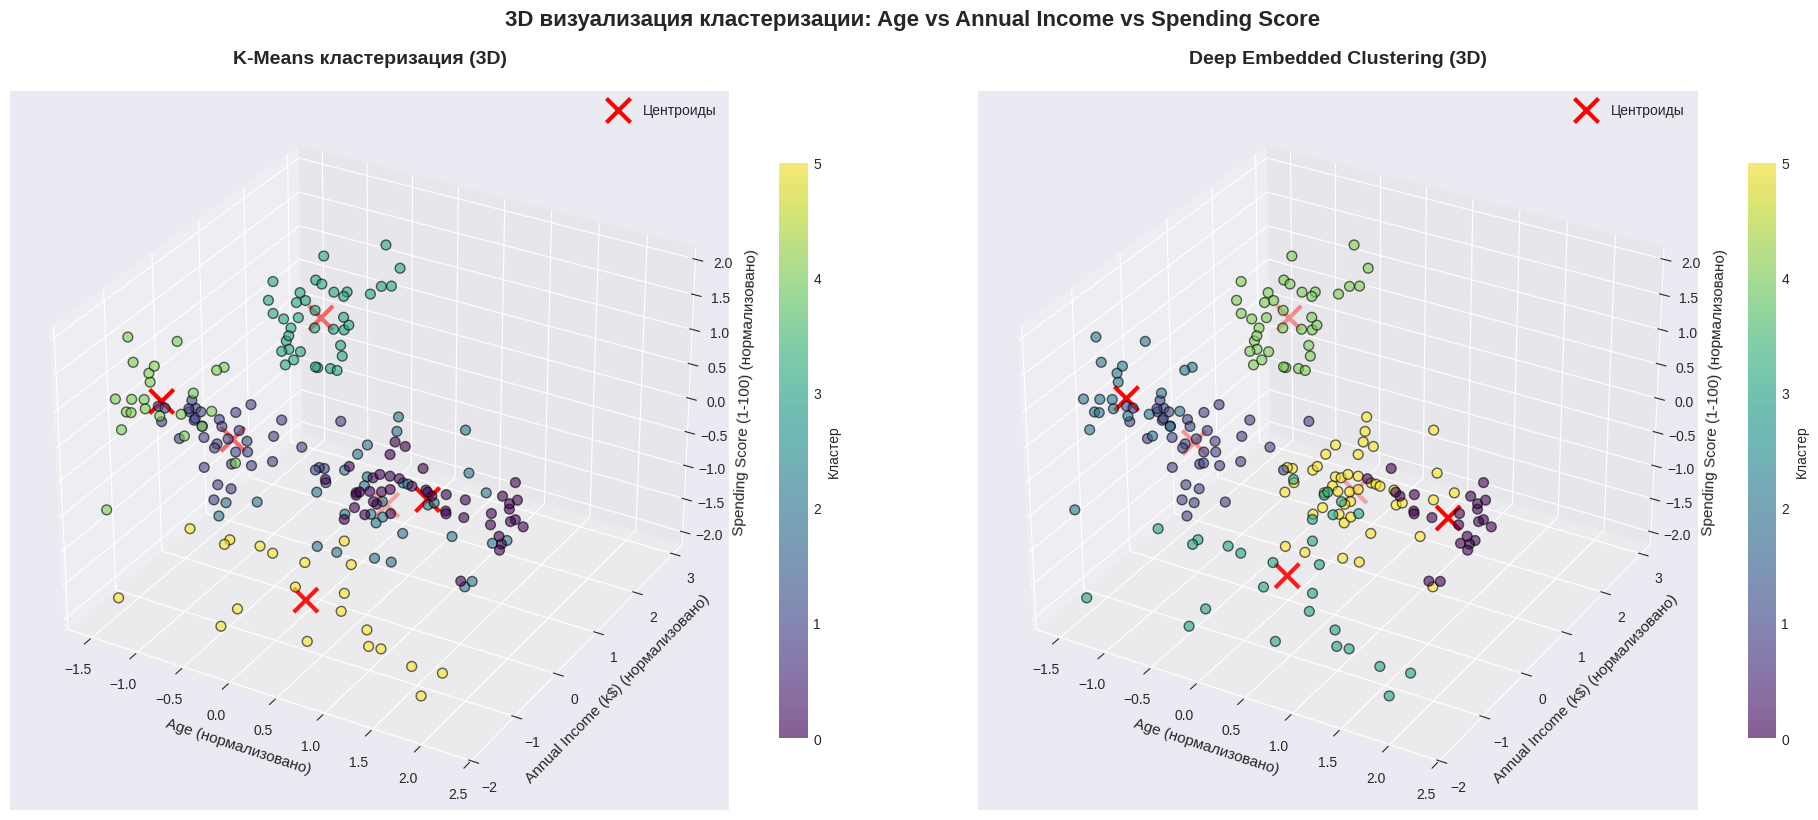

In [14]:
#@title 3D визуализация результатов кластеризации
# Создаем 3D визуализацию для всех трех признаков
fig = plt.figure(figsize=(20, 8))

# Индексы признаков для 3D визуализации
age_idx = features.index('Age')
income_idx = features.index('Annual Income (k$)')
spending_idx = features.index('Spending Score (1-100)')

# K-Means 3D визуализация
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_scaled[:, age_idx],
                      X_scaled[:, income_idx],
                      X_scaled[:, spending_idx],
                      c=kmeans_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='black')

# Отображаем центроиды K-Means в 3D
ax1.scatter(kmeans_centroids[:, age_idx],
           kmeans_centroids[:, income_idx],
           kmeans_centroids[:, spending_idx],
           marker='x', s=300, c='red', linewidths=3, label='Центроиды')

ax1.set_xlabel('Age (нормализовано)', fontsize=11)
ax1.set_ylabel('Annual Income (k$) (нормализовано)', fontsize=11)
ax1.set_zlabel('Spending Score (1-100) (нормализовано)', fontsize=11)
ax1.set_title('K-Means кластеризация (3D)', fontsize=14, fontweight='bold', pad=20)
ax1.legend()
plt.colorbar(scatter1, ax=ax1, label='Кластер', shrink=0.8)

# DEC 3D визуализация
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_scaled[:, age_idx],
                      X_scaled[:, income_idx],
                      X_scaled[:, spending_idx],
                      c=dec_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='black')

# Вычисляем центроиды DEC в исходном пространстве признаков
if 'dec_centroids' not in locals() or dec_centroids is None:
    dec_centroids = []
    unique_dec_labels = np.unique(dec_labels)
    for cluster_id in sorted(unique_dec_labels):
        cluster_mask = dec_labels == cluster_id
        if np.sum(cluster_mask) > 0:
            centroid = np.mean(X_scaled[cluster_mask], axis=0)
            dec_centroids.append(centroid)
    dec_centroids = np.array(dec_centroids)

# Отображаем центроиды DEC в 3D
if len(dec_centroids) > 0:
    ax2.scatter(dec_centroids[:, age_idx],
               dec_centroids[:, income_idx],
               dec_centroids[:, spending_idx],
               marker='x', s=300, c='red', linewidths=3, label='Центроиды')

ax2.set_xlabel('Age (нормализовано)', fontsize=11)
ax2.set_ylabel('Annual Income (k$) (нормализовано)', fontsize=11)
ax2.set_zlabel('Spending Score (1-100) (нормализовано)', fontsize=11)
ax2.set_title('Deep Embedded Clustering (3D)', fontsize=14, fontweight='bold', pad=20)
ax2.legend()
plt.colorbar(scatter2, ax=ax2, label='Кластер', shrink=0.8)

plt.suptitle('3D визуализация кластеризации: Age vs Annual Income vs Spending Score',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


АНАЛИЗ КЛАСТЕРОВ K-MEANS

Кластер 0 (45 клиентов):
  Средний возраст: 56.3 лет
  Средний годовой доход: $54.3k
  Средний Spending Score: 49.1
  Распределение по полу: {'Female': 26, 'Male': 19}

Кластер 1 (39 клиентов):
  Средний возраст: 26.8 лет
  Средний годовой доход: $57.1k
  Средний Spending Score: 48.1
  Распределение по полу: {'Female': 25, 'Male': 14}

Кластер 2 (33 клиентов):
  Средний возраст: 41.9 лет
  Средний годовой доход: $88.9k
  Средний Spending Score: 17.0
  Распределение по полу: {'Male': 19, 'Female': 14}

Кластер 3 (39 клиентов):
  Средний возраст: 32.7 лет
  Средний годовой доход: $86.5k
  Средний Spending Score: 82.1
  Распределение по полу: {'Female': 21, 'Male': 18}

Кластер 4 (23 клиентов):
  Средний возраст: 25.0 лет
  Средний годовой доход: $25.3k
  Средний Spending Score: 77.6
  Распределение по полу: {'Female': 13, 'Male': 10}

Кластер 5 (21 клиентов):
  Средний возраст: 45.5 лет
  Средний годовой доход: $26.3k
  Средний Spending Score: 19.4
  Распределе

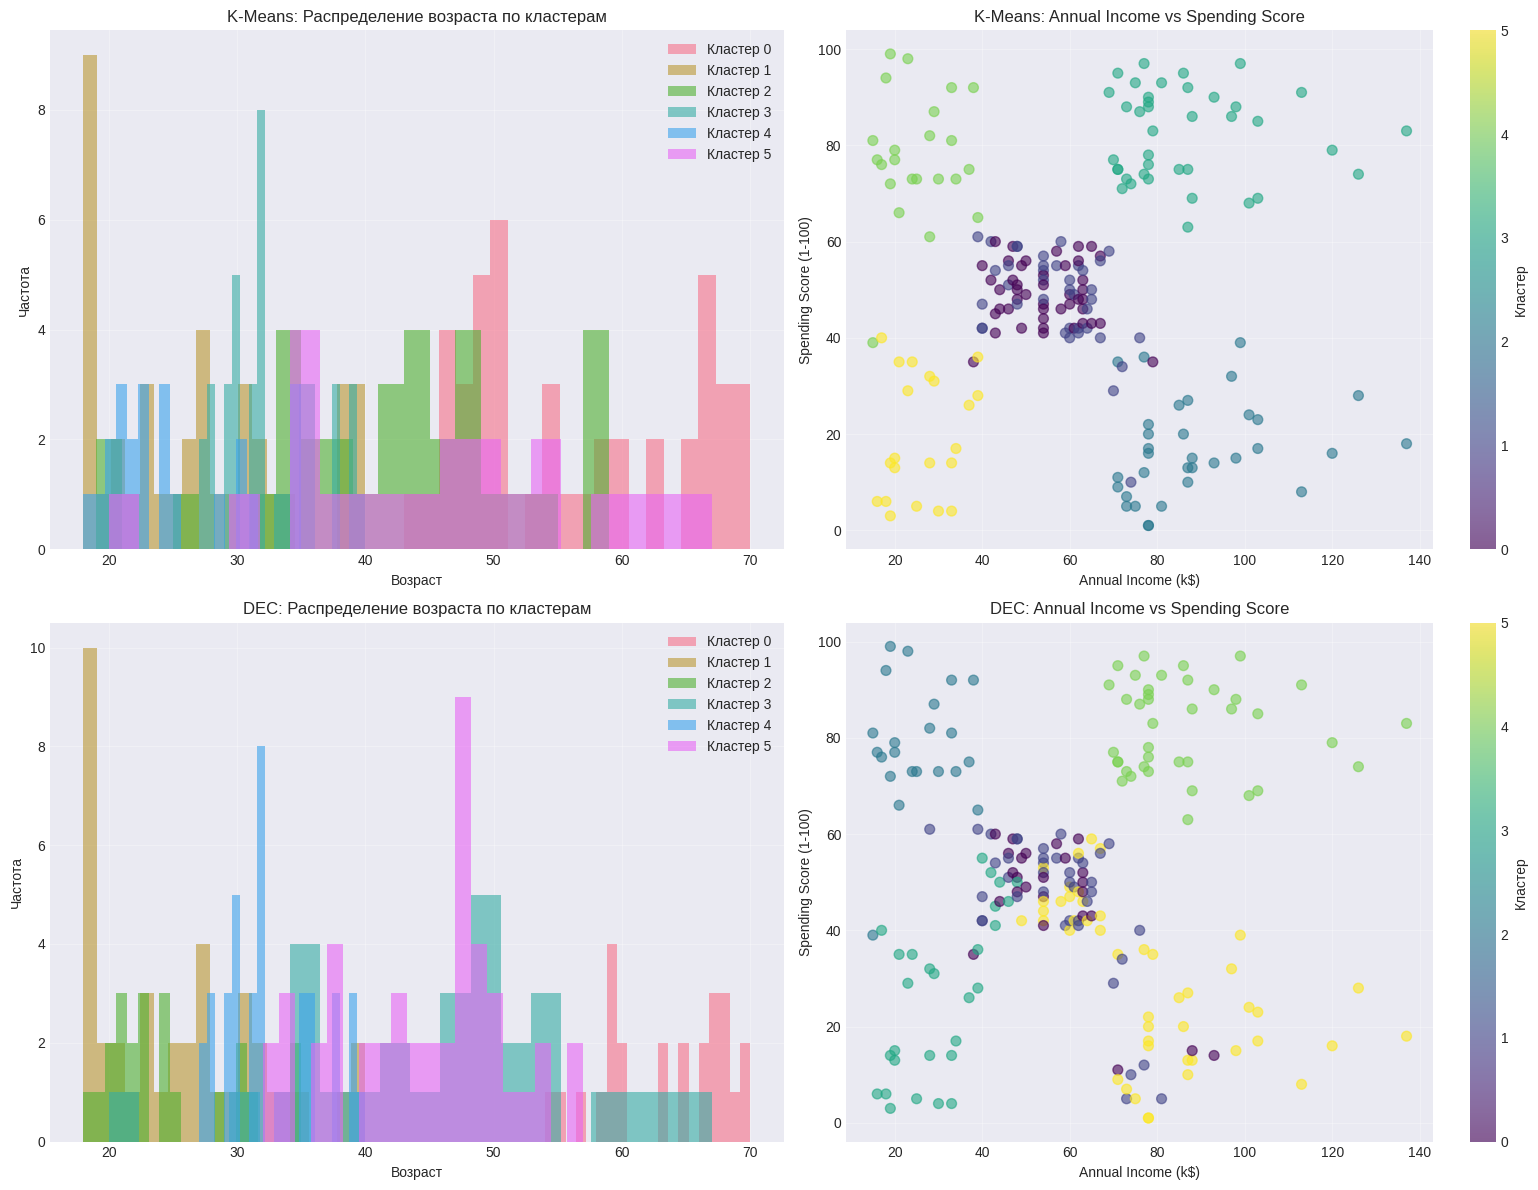

In [15]:
#@title Анализ кластеров
# Добавляем метки кластеров в исходный датасет для анализа
df_results = df_processed.copy()
df_results['KMeans_Cluster'] = kmeans_labels
df_results['DEC_Cluster'] = dec_labels

# Проверяем количество уникальных кластеров
unique_kmeans_clusters = np.unique(kmeans_labels)
unique_dec_clusters = np.unique(dec_labels)

# Анализ кластеров K-Means
print("\n" + "="*70)
print("АНАЛИЗ КЛАСТЕРОВ K-MEANS")
print("="*70)
for cluster_id in sorted(unique_kmeans_clusters):
    cluster_data = df_results[df_results['KMeans_Cluster'] == cluster_id]
    if len(cluster_data) > 0:
        print(f"\nКластер {cluster_id} ({len(cluster_data)} клиентов):")
        print(f"  Средний возраст: {cluster_data['Age'].mean():.1f} лет")
        print(f"  Средний годовой доход: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
        print(f"  Средний Spending Score: {cluster_data['Spending Score (1-100)'].mean():.1f}")
        print(f"  Распределение по полу: {cluster_data['Genre'].value_counts().to_dict()}")
    else:
        print(f"\nКластер {cluster_id}: пустой (0 клиентов) - это не должно происходить!")

# Анализ кластеров DEC
print("\n" + "="*70)
print("АНАЛИЗ КЛАСТЕРОВ DEEP EMBEDDED CLUSTERING")
print("="*70)
for cluster_id in sorted(unique_dec_clusters):
    cluster_data = df_results[df_results['DEC_Cluster'] == cluster_id]
    if len(cluster_data) > 0:
        print(f"\nКластер {cluster_id} ({len(cluster_data)} клиентов):")
        print(f"  Средний возраст: {cluster_data['Age'].mean():.1f} лет")
        print(f"  Средний годовой доход: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
        print(f"  Средний Spending Score: {cluster_data['Spending Score (1-100)'].mean():.1f}")
        print(f"  Распределение по полу: {cluster_data['Genre'].value_counts().to_dict()}")
    else:
        print(f"\nКластер {cluster_id}: пустой (0 клиентов) - это не должно происходить!")

# Визуализация распределения признаков по кластерам
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# K-Means: Age распределение
ax1 = axes[0, 0]
for cluster_id in sorted(unique_kmeans_clusters):
    cluster_data = df_results[df_results['KMeans_Cluster'] == cluster_id]
    if len(cluster_data) > 0:
        ax1.hist(cluster_data['Age'], alpha=0.6, label=f'Кластер {cluster_id}', bins=20)
ax1.set_xlabel('Возраст')
ax1.set_ylabel('Частота')
ax1.set_title('K-Means: Распределение возраста по кластерам')
ax1.legend()
ax1.grid(True, alpha=0.3)

# K-Means: Annual Income vs Spending Score
ax2 = axes[0, 1]
scatter = ax2.scatter(df_results['Annual Income (k$)'],
                     df_results['Spending Score (1-100)'],
                     c=df_results['KMeans_Cluster'], cmap='viridis', s=50, alpha=0.6)
ax2.set_xlabel('Annual Income (k$)')
ax2.set_ylabel('Spending Score (1-100)')
ax2.set_title('K-Means: Annual Income vs Spending Score')
plt.colorbar(scatter, ax=ax2, label='Кластер')
ax2.grid(True, alpha=0.3)

# DEC: Age распределение
ax3 = axes[1, 0]
for cluster_id in sorted(unique_dec_clusters):
    cluster_data = df_results[df_results['DEC_Cluster'] == cluster_id]
    if len(cluster_data) > 0:
        ax3.hist(cluster_data['Age'], alpha=0.6, label=f'Кластер {cluster_id}', bins=20)
ax3.set_xlabel('Возраст')
ax3.set_ylabel('Частота')
ax3.set_title('DEC: Распределение возраста по кластерам')
ax3.legend()
ax3.grid(True, alpha=0.3)

# DEC: Annual Income vs Spending Score
ax4 = axes[1, 1]
scatter = ax4.scatter(df_results['Annual Income (k$)'],
                     df_results['Spending Score (1-100)'],
                     c=df_results['DEC_Cluster'], cmap='viridis', s=50, alpha=0.6)
ax4.set_xlabel('Annual Income (k$)')
ax4.set_ylabel('Spending Score (1-100)')
ax4.set_title('DEC: Annual Income vs Spending Score')
plt.colorbar(scatter, ax=ax4, label='Кластер')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводы по проделанной работе

В рамках данного исследования мной была выполнена сравнительная кластеризация датасета Mall Customers с использованием двух методов: традиционного K-Means и современного подхода на основе глубокого обучения - Deep Embedded Clustering (DEC). Для реализации использовались технологии машинного обучения (scikit-learn для K-Means и метрик оценки), глубокого обучения (TensorFlow/Keras для построения автоэнкодера и DEC модели), а также библиотеки для визуализации (matplotlib, seaborn) и обработки данных (pandas, numpy). Определение оптимального количества кластеров проводилось с использованием трех метрик: Silhouette Score, Calinski-Harabasz Score и Davies-Bouldin Score, которые показали оптимальное значение K=6.

Для улучшения качества обучения DEC были применены следующие оптимизации: увеличение количества эпох предобучения автоэнкодера до 200 для лучшего извлечения признаков, использование dropout-регуляризации (0.2) для предотвращения переобучения на малом датасете, реализация механизма отслеживания лучшего результата по Silhouette Score с ранней остановкой (patience=20), а также настройка параметров оптимизации включая строгий критерий сходимости (tol=0.001) и минимальное количество итераций (min_iter=50) для обеспечения достаточной оптимизации. Дополнительно была реализована стратегия выполнения нескольких шагов обучения на каждой итерации (3 шага) для улучшения сходимости алгоритма.

Однако, несмотря на все оптимизации, для данного конкретного датасета K-Means показал лучшие результаты по всем метрикам: Silhouette Score (0.428 vs 0.360), Calinski-Harabasz Score (135.1 vs 103.8) и Davies-Bouldin Score (0.825 vs 0.958). Причина, по которой DEC не оптимален для данной задачи, заключается в специфике датасета: небольшой размер выборки (200 строк) и низкая размерность признакового пространства (3 признака) не позволяют глубокой нейронной сети раскрыть свой потенциал. DEC эффективен на больших многомерных датасетах, где автоэнкодер может извлечь сложные нелинейные зависимости и скрытые паттерны, но для простой структуры данных с линейно разделимыми кластерами традиционный K-Means оказывается более подходящим и эффективным решением.

Кроме того, K-Means требует значительно меньше вычислительных ресурсов и времени на обучение (секунды против минут), что делает его предпочтительным выбором для задач такого масштаба. Анализ кластеров показал, что оба метода успешно выделили различные сегменты клиентов: молодые клиенты с низким доходом и высоким spending score, клиенты среднего возраста с высоким доходом и высоким spending score, пожилые клиенты с низким spending score и другие характерные группы. Однако K-Means создал более сбалансированные кластеры с лучшей разделимостью.

Интересное наблюдение касается расхождения между визуальной оценкой и метриками: на 2D графике (Annual Income vs Spending Score) визуально выделяются 5 кластеров, в то время как метрики указывают на оптимальное количество кластеров равное 6. Это объясняется тем, что кластеризация выполняется во всем трехмерном пространстве признаков (Age, Annual Income, Spending Score), а визуализация показывает только проекцию на две оси. Метрики учитывают разделение по всем трем признакам одновременно, и шестой кластер, вероятно, отличается от других в первую очередь по признаку Age, что не видно в 2D проекции. Это демонстрирует важность использования метрик качества кластеризации, которые объективно оценивают результаты во всем пространстве признаков, а не только в визуально наблюдаемой проекции. Трехмерная визуализация подтвердила наличие шестого кластера, который визуально не различим в двумерной проекции, что подчеркивает ограничения визуального анализа при работе с многомерными данными.